# Extended Information Filter Test

State

$\mathbf{x}_t = \begin{bmatrix} x_t & y_t & \theta_t & m_x & m_y\end{bmatrix}^T$

Motion Model ($\Delta t$ is omitted)

$u_t = \begin{bmatrix} v_t & \omega_t \end{bmatrix}^T$

$\begin{bmatrix}x_t \\ y_t \\ \theta_t \end{bmatrix} = \begin{bmatrix}x_{t-1} \\ y_{t-1} \\ \theta_{t-1} \end{bmatrix} + \begin{bmatrix} -v_t/\omega_t sin\theta_t + v_t/\omega_t sin\left(\theta_t + \omega_t \right) \\ v_t/\omega_t sin\theta_t - v_t/\omega_t sin\left(\theta_t + \omega_t\right) \\ \omega_t \end{bmatrix}$

Measurement Model

$ \begin{bmatrix} r \\ \phi \end{bmatrix} = \begin{bmatrix} \sqrt{(m_x - x_t)^2 + (m_y - y_t)^2} \\ tan^{-1} \frac{m_y - y_t}{m_x - x_t} - \theta_t \end{bmatrix}$

In [620]:
import sympy as sp
import IPython.display

x, y, theta = sp.symbols('x y \\theta')
mx, my = sp.symbols('m_x m_y')

dx = mx - x
dy = my - y
r = sp.sqrt(dx**2 + dy**2)
phi = sp.atan2(dy, dx) - theta

display(r)
display(phi)

drdx     = r.diff(x)
drdy     = r.diff(y)
drdtheta = r.diff(theta)
drdmx    = r.diff(mx)
drdmy    = r.diff(my)

dpdx     = phi.diff(x)
dpdy     = phi.diff(y)
dpdtheta = phi.diff(theta)
dpdmx    = phi.diff(mx)
dpdmy    = phi.diff(my)

H = sp.Matrix([
    [drdx, drdy, drdtheta, drdmx, drdmy],
    [dpdx, dpdy, dpdtheta, dpdmx, dpdmy],
])

display(H)


sqrt((m_x - x)**2 + (m_y - y)**2)

-\theta + atan2(m_y - y, m_x - x)

Matrix([
[(-m_x + x)/sqrt((m_x - x)**2 + (m_y - y)**2), (-m_y + y)/sqrt((m_x - x)**2 + (m_y - y)**2),  0, (m_x - x)/sqrt((m_x - x)**2 + (m_y - y)**2), (m_y - y)/sqrt((m_x - x)**2 + (m_y - y)**2)],
[   -(-m_y + y)/((m_x - x)**2 + (m_y - y)**2),     -(m_x - x)/((m_x - x)**2 + (m_y - y)**2), -1,    (-m_y + y)/((m_x - x)**2 + (m_y - y)**2),     (m_x - x)/((m_x - x)**2 + (m_y - y)**2)]])

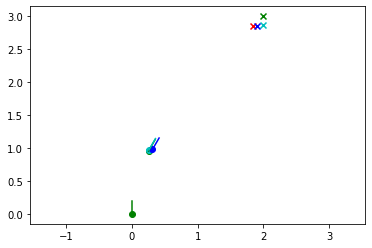

In [621]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure('map')

def move(xt, ut):
    x0     = xt[0,0]
    y0     = xt[1,0]
    theta0 = xt[2,0]
    mx0    = xt[3,0]
    my0    = xt[4,0]

    vt = ut[0,0]
    wt = ut[1,0]

    x1 = x0 - vt/wt*np.sin(theta0) + vt/wt*np.sin(theta0 + wt)
    y1 = y0 + vt/wt*np.cos(theta0) - vt/wt*np.cos(theta0 + wt)
    theta1 = theta0 + wt
    mx1 = mx0
    my1 = my0

    x1 = np.array([[x1, y1, theta1, mx1, my1]]).T
    return x1

def draw_robot(x, y, theta, c='b'):
    plt.scatter(x, y, c=c)
    d = 0.2
    dx = d*np.cos(theta)
    dy = d*np.sin(theta)
    plt.plot([x, x+dx], [y, y+dy], c=c)

def draw(xt, c='b'):
    x, y, theta, mx, my = xt
    draw_robot(x, y, theta, c=c)

    # draw map
    plt.scatter(mx, my, c=c, marker='x')
    plt.axis('equal')


xt0 = np.array([[0, 0, np.pi/2, 2, 3]]).T
draw(xt0, c='g')

# control
# ut = np.array([[1, -np.pi/6]]).T
ut = np.array([[1, -np.pi/6]]).T
xt = move(xt0, ut)
dx = xt[0,0] - xt0[0,0]
dy = xt[1,0] - xt0[1,0]
dtheta = xt[2,0] - xt0[2,0]
r = np.sqrt(dx**2 + dy**2)

# print(r)
# print(dtheta * 180 / np.pi)

draw_robot(xt[0,0], xt[1,0], xt[2,0], c='g')

# EIF test
std_x0 = 1.0
std_y0 = 1.0
std_theta0 = 10*np.pi / 180.0
std_mx0 = 1.0
std_my0 = 1.0

std_v = 0.1
std_w = 0.01

std_r = 0.1
std_phi = 0.01

def predict(xi, O, ut):
    invO = np.linalg.inv(O) #Omega^-1 = Sigma
    xt = np.matmul(invO, xi)

    x0     = xt[0,0]
    y0     = xt[1,0]
    theta0 = xt[2,0]
    mx0    = xt[3,0]
    my0    = xt[4,0]

    vt = ut[0,0] + np.random.randn()*std_v
    wt = ut[1,0] + np.random.randn()*std_w

    x1     = x0 - vt/wt*np.sin(theta0) + vt/wt*np.sin(theta0 + wt)
    y1     = y0 + vt/wt*np.cos(theta0) - vt/wt*np.cos(theta0 + wt)
    theta1 = theta0 + wt

    std_vx = std_v*np.cos(theta0)
    std_vy = std_v*np.sin(theta0)

    mx1 = mx0 + np.random.randn()*std_vx
    my1 = my0 + np.random.randn()*std_vy
    xt1 = np.array([[x1, y1, theta1, mx1, my1]]).T

    # dx1/dx, dx1/dy, dx1/dtheta
    # dy1/dx, dy1/dy, dy1/dtheta
    # dtheta1/dx, dtheta1/dy, dtheta1/dtheta
    Gt = np.array([
        [1, 0, -vt/wt*np.cos(theta0) + vt/wt*np.cos(theta0 + wt)],
        [0, 1, -vt/wt*np.sin(theta0) + vt/wt*np.sin(theta0 + wt)],
        [0, 0, 1]
    ])

    Rt = np.array([
        [std_vx**2, 0,         0],
        [0,         std_vy**2, 0],
        [0,         0,         std_w**2]
    ])    
    
    Op = O.copy()
    Op[:3,:3] += np.linalg.inv(np.matmul(np.matmul(Gt, invO[:3,:3]), Gt.T) + Rt)
    xip = np.matmul(Op, xt1)

    return xip, Op

def measure(xt):
    x     = xt[0,0]
    y     = xt[1,0]
    theta = xt[2,0]
    mx    = xt[3,0]
    my    = xt[4,0]

    dx = mx - x
    dy = my - y

    r = np.sqrt(dx**2 + dy**2)
    phi = np.arctan2(dy, dx) - theta

    if phi > np.pi:
        phi -= 2*np.pi
    elif phi < -np.pi:
        phi += 2*np.pi

    r += np.random.randn()*std_r
    phi += np.random.randn()*std_phi

    zt = np.array([[r, phi]]).T
    return zt

def update(xip, Op, zt):
    invOp = np.linalg.inv(Op) #Omega^-1 = Sigma
    xp = np.matmul(invOp, xip)

    x     = xp[0,0]
    y     = xp[1,0]
    theta = xp[2,0]
    mx    = xp[3,0]
    my    = xp[4,0]

    dx = mx - x
    dy = my - y
    q = dx**2 + dy**2
    r = np.sqrt(q)
    phi = np.arctan2(dy, dx) - theta
    if phi > np.pi:
        phi -= 2*np.pi
    elif phi < -np.pi:
        phi += 2*np.pi
    zt_pred = np.array([[r, phi]]).T

    H = np.array([
        [-dx/r, -dy/r,  0,  dx/r, dy/r],
        [ dy/q, -dx/q, -1, -dy/q, dx/q],
    ], dtype=np.float64)

    Q = np.array([
        [std_r**2, 0],
        [0,        std_phi**2]
    ])
    invQ = np.linalg.inv(Q)

    O = Op + np.matmul(np.matmul(H.T, invQ), H)
    xi = xip + np.matmul(np.matmul(H.T, invQ), zt - zt_pred + np.matmul(H, xp))

    return xi, O

# print(xt0)
P0 = np.zeros([5,5])
P0[0,0] = std_x0**2
P0[1,1] = std_y0**2
P0[2,2] = std_theta0**2
P0[3,3] = std_mx0**2
P0[4,4] = std_mx0**2
# print(P0)

# Information Matrix
O = np.linalg.inv(P0)

# Information Vector
xi = np.matmul(O, xt0)

xip, Op = predict(xi, O, ut)
xtp = np.matmul(np.linalg.inv(Op), xip)
draw(xtp, c='c')

xt_gt = move(xt0, ut)
zt = measure(xt_gt)
r = zt[0,0]
phi = zt[1,0] + xtp[2,0]
zx = r*np.cos(phi) + xtp[0,0]
zy = r*np.sin(phi) + xtp[1,0]
plt.scatter(zx, zy, c='r', marker='x')

xi, O = update(xip, Op, zt)
xt = np.matmul(np.linalg.inv(O), xi)
draw(xt, c='b')

